<a href="https://colab.research.google.com/github/lodi-m/US-Traffic-Accidents-Analysis/blob/main/EDA_us_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Traffic Accidents Exploratory Data Analysis

## Introduction

### What is Exploratory Data Analysis (EDA)? 
Exploratory data analysis is used to investigate datasets to summarize their main characteristics and draw conclusions *before* any formal statistical modeling or inference is made. It is a crucial first step in the data analysis procedure as it help save time and resources in the future. EDA is especially useful in discovering patterns, locating any abnormalities and finding any interesting relations in the data.

In this notebook we'll analyze a car accident dataset from the USA. This current version of the dataset contains information from 4.2 million traffic accidents during *February 2016* - *December 2020* that took place all over the Contiguous United States. The data was collected using multiple Traffic APIs, such as MapQuest and Bing, and several other data providers. 

Although this dataset can be used for a variety of applications, we will be focusing on how **precipitation** and other **environmental factors** impacted the accidents. 

If you would like to learn more about the raw data itself please visit: https://smoosavi.org/datasets/us_accidents 


#### Downloading the data


In [2]:
pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/sobhanmoosavi/us-accidents" 
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: malihalodi
Your Kaggle Key: ··········


100%|██████████| 290M/290M [00:02<00:00, 103MB/s] 


### Data Preparation and Cleaning 



In [4]:
import pandas as pd
import numpy as np
import seaborn as sns 
import folium
from folium.plugins import HeatMap
sns.set_style("darkgrid")

In [5]:
raw_df = pd.read_csv("/content/us-accidents/US_Accidents_Dec20_Updated.csv")

In [6]:
raw_df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

As you can see, there is a lot more information than we want currently in the dataset. For example, we won't really need to worry about what amenities there were or if there was a roundabout near the accident. We are only focused on the *environmental factors* in this notebook. 

Please also note that we will only be looking at the time of day in relation to Nautical Twilight. This is because Nautical Twilight takes place right in between Civil and Astronomical Twilight. I felt that if we used the other twilights, there would be a bit of bias in regards to what is considered "Day" or "Night". As such, I chose to just use the middle value. 

<img src="https://c.tadst.com/gfx/1200x630/twiligh-phases.png?1" alt="Different Types of Twilights and their degrees" width="500"/>

If you would like to read more about the differences between Civil, Nautical, and Astronomical Twilight please visit: https://www.weather.gov/lmk/twilight-types



Now let's go ahead and only select the columns we are interested in. 

In [7]:
selected_columns = ['ID', 'Severity', 'Start_Time', 'End_Time',
                     'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
                    'Description', 'City', 'State', 'Timezone', 'Weather_Timestamp',
                    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                    'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
                    'Precipitation(in)', 'Weather_Condition', 
                    'Sunrise_Sunset', 'Nautical_Twilight']

len(selected_columns)

25

In [8]:
len(raw_df.columns)

47

Note that we've about halved the amount of columns! That's about half of the dataset that we're not interested in. 

Let's now go ahead and make a new copy of the data, containing only the information we want called <code> weather_df </code>. Using <code> weather_df </code>, we can continue to modify and analyze further without actually affecting the original data and dataframe.

In [9]:
weather_df = raw_df[selected_columns].copy()

Let's just get a better idea of whats inside <code>weather_df</code>

In [10]:
weather_df.shape

(2906610, 25)

In [11]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906610 entries, 0 to 2906609
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ID                 object 
 1   Severity           int64  
 2   Start_Time         object 
 3   End_Time           object 
 4   Start_Lat          float64
 5   Start_Lng          float64
 6   End_Lat            float64
 7   End_Lng            float64
 8   Distance(mi)       float64
 9   Description        object 
 10  City               object 
 11  State              object 
 12  Timezone           object 
 13  Weather_Timestamp  object 
 14  Temperature(F)     float64
 15  Wind_Chill(F)      float64
 16  Humidity(%)        float64
 17  Pressure(in)       float64
 18  Visibility(mi)     float64
 19  Wind_Direction     object 
 20  Wind_Speed(mph)    float64
 21  Precipitation(in)  float64
 22  Weather_Condition  object 
 23  Sunrise_Sunset     object 
 24  Nautical_Twilight  object 
dtypes: float64(12), in

Before moving forwards, let's also take care of any missing or Null values. We'll first see exactly how many missing values we have. 

In [12]:
missing_percentage = weather_df.isna().sum().sort_values(ascending = False) / len(weather_df)
missing_percentage

Precipitation(in)    0.447713
Wind_Chill(F)        0.407299
Wind_Speed(mph)      0.105677
End_Lng              0.097303
End_Lat              0.097303
Visibility(mi)       0.024798
Weather_Condition    0.024720
Humidity(%)          0.024520
Temperature(F)       0.023128
Wind_Direction       0.021838
Pressure(in)         0.019579
Weather_Timestamp    0.016141
Timezone             0.001180
Nautical_Twilight    0.000038
Sunrise_Sunset       0.000038
City                 0.000037
Description          0.000000
Distance(mi)         0.000000
State                0.000000
Start_Lng            0.000000
Start_Lat            0.000000
End_Time             0.000000
Start_Time           0.000000
Severity             0.000000
ID                   0.000000
dtype: float64

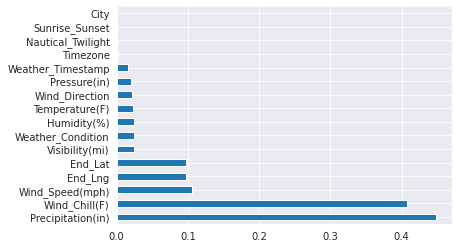

In [13]:
missing_percentage[missing_percentage != 0].plot(kind = "barh")

From the graph we can see that *End_Lat* and *End_Lng* have the greatest amount of missing values, followed by *Precipitation* and *Wind_Chill*. 

We won't worry about the missing *End_Lat* and *End_Lng* values ***just*** yet as these missing values may indicate that that the vehicle simply did not move after the accident. In some states, moving the car after a crash is actually illegal so this may also be a factor in the missing values. 



In [14]:
weather_df.dropna(subset = ["Humidity(%)", "Weather_Condition", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Wind_Chill(F)"], inplace=True)

Let's just making sure that the missing values were actually dropped. 
Note that we are not dropping *all* of the columns. The remaining ones just have such a small amount of missing values that it won't really have an affect on the analysis down the road. 

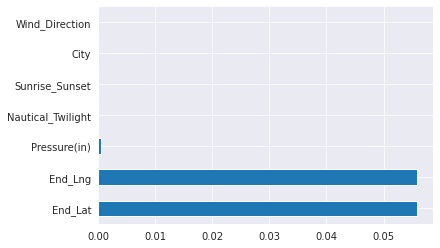

In [15]:
missing_percentage = weather_df.isna().sum().sort_values(ascending = False) / len(weather_df)
missing_percentage[missing_percentage != 0].plot(kind = "barh")

I will also go ahead and save this data for easy use in the future. By doing so, I won't have to start with the raw dataset and clean it every single time I work on this project.

In [26]:
weather_df.to_csv(r'/content/us-accidents/clean_data.csv', index = False)

Now that all of the missing values have been dealt with, lets actually get into the data and see if there are any incorrect values.

Let's start off with some basic statistics. 

In [16]:
weather_df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,1.462742e+06,1.462742e+06,1.462742e+06,1.381003e+06,1.381003e+06,1.462742e+06,1.462742e+06,1.462742e+06,1.462742e+06,1.462034e+06,1.462742e+06,1.462742e+06,1.462742e+06
mean,2.203830e+00,3.659601e+01,-9.672085e+01,3.654948e+01,-9.646967e+01,4.375578e-01,5.984798e+01,5.850785e+01,6.612227e+01,2.934691e+01,8.953615e+00,7.175253e+00,6.448827e-03
std,5.144949e-01,5.119588e+00,1.793836e+01,5.140887e+00,1.787470e+01,1.649376e+00,1.829572e+01,2.045406e+01,2.299925e+01,1.107690e+00,2.778253e+00,5.580180e+00,8.207617e-02
min,1.000000e+00,2.455527e+01,-1.244976e+02,2.455527e+01,-1.244975e+02,0.000000e+00,-2.700000e+01,-5.270000e+01,1.000000e+00,1.937000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.372973e+01,-1.179175e+02,3.368313e+01,-1.178586e+02,0.000000e+00,4.700000e+01,4.500000e+01,5.000000e+01,2.917000e+01,1.000000e+01,3.000000e+00,0.000000e+00
50%,2.000000e+00,3.612933e+01,-9.143870e+01,3.607528e+01,-9.112135e+01,0.000000e+00,6.100000e+01,6.100000e+01,7.000000e+01,2.968000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.057520e+01,-8.080292e+01,4.054426e+01,-8.075835e+01,2.820000e-01,7.400000e+01,7.400000e+01,8.600000e+01,2.995000e+01,1.000000e+01,1.000000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.748413e+01,4.907500e+01,-6.748413e+01,2.512200e+02,1.740000e+02,1.740000e+02,1.000000e+02,5.804000e+01,1.000000e+02,9.840000e+02,2.400000e+01


There seems to be a problem with the Distance(mi) column. The maximum distance is a car moved during the accident is about 251 miles. This value seems a bit too high, and as such, seems unreliable and unrealistic.  

There are similiar problems with Temperature(F), Wind_Chill(F) and Wind_Speed(mph) columns. The maximum value in each of these columns seems too high to be realistic. For example, it does not make sense that the temperature during the accident was 174 degrees Farenheit when the highest recorded temperature ever on Earth is 134 degrees Farenheit (set on July 10, 1913). 

A simple fix for these unrealistic and unreliable values are to simply exclude them from our analysis. 

In [17]:
weather_df.drop(weather_df[weather_df["Distance(mi)"] > 100].index, inplace=True)
weather_df.drop(weather_df[weather_df["Temperature(F)"] > 134].index, inplace=True)
weather_df.drop(weather_df[weather_df["Wind_Chill(F)"] > 60].index, inplace=True)
weather_df.drop(weather_df[weather_df["Wind_Speed(mph)"] > 231].index, inplace=True)

In [18]:
weather_df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,712816.000000,712816.000000,712816.000000,670875.000000,670875.000000,712816.000000,712816.000000,712816.000000,712816.000000,712425.000000,712816.000000,712816.000000,712816.000000
mean,2.192585,38.604513,-97.390789,38.573880,-97.192285,0.480983,44.520303,41.770337,73.424398,29.283090,8.408848,6.763847,0.007721
std,0.495585,4.494895,18.540248,4.516422,18.505757,1.624178,11.848420,14.960839,19.355494,1.242086,3.154094,5.762795,0.107808
min,1.000000,24.574326,-124.497567,24.574546,-124.497478,0.000000,-27.000000,-52.700000,4.000000,19.480000,0.000000,0.000000,0.000000
25%,2.000000,34.789993,-118.226471,34.766392,-118.199341,0.000000,37.000000,33.000000,61.000000,29.130000,8.000000,3.000000,0.000000
50%,2.000000,38.891848,-93.217866,38.882228,-93.164062,0.010000,47.000000,44.000000,78.000000,29.640000,10.000000,6.000000,0.000000
75%,2.000000,41.909622,-80.481331,41.904583,-80.276722,0.367000,54.000000,54.000000,89.000000,29.970000,10.000000,10.000000,0.000000
max,4.000000,49.002201,-67.484130,49.075000,-67.484130,99.791000,60.000000,60.000000,100.000000,58.040000,100.000000,230.000000,24.000000


In [19]:
weather_df['ID'].count()

712816

#### Note that we only have about 712 000 entries left in our dataset after cleaning and preparing it! We originally had over 4.2 million entries. That's about 3 million entries which were unusable for either containing null/missing values or have unrealistic information inside. 

#### We've now cleaned up and prepared the dataset for analysis. Let's take a look at a sample of rows from the data frame. 

In [20]:
weather_df.sample(10)

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,City,State,Timezone,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Nautical_Twilight
327342,A-327343,3,2019-12-11 10:59:40,2019-12-11 12:30:18,32.681732,-96.744240,32.681732,-96.744240,0.000,One lane blocked due to accident on I-45 North...,Dallas,TX,US/Central,2019-12-11 10:53:00,45.0,42.0,58.0,29.80,10.0,SSE,6.0,0.00,Fair,Day,Day
1642242,A-1642243,3,2020-03-15 23:50:02,2020-03-16 00:19:54,33.854110,-117.886390,33.854230,-117.893490,0.407,At State College Blvd - Accident.,Anaheim,CA,US/Pacific,2020-03-15 23:53:00,59.0,59.0,55.0,29.99,10.0,CALM,0.0,0.00,Cloudy,Night,Night
582816,A-582817,2,2020-12-31 01:12:04,2020-12-31 09:12:04,45.597959,-121.137937,45.598387,-121.138912,0.056,Rock fall has occurred causing no to minimum d...,The Dalles,OR,US/Pacific,2020-12-31 00:53:00,35.0,35.0,100.0,29.71,4.0,CALM,0.0,0.00,Cloudy,Night,Night
467188,A-467189,2,2020-10-31 22:27:57,2020-11-01 00:09:01,40.732928,-74.220825,40.736956,-74.218065,0.314,Incident on GARDEN STATE PKWY NB near COUNTY H...,Irvington,NJ,US/Eastern,2020-10-31 22:51:00,43.0,39.0,65.0,30.39,10.0,S,6.0,0.00,Fair,Night,Night
2134780,A-2134781,2,2020-03-03 06:22:27,2020-03-03 07:13:18,35.348660,-97.405922,35.348660,-97.405922,0.000,Accident on Air Depot Blvd at 119th St.,Oklahoma City,OK,US/Central,2020-03-03 05:56:00,45.0,39.0,76.0,28.46,10.0,ENE,12.0,0.00,Fair,Night,Day
1296795,A-1296796,2,2020-12-19 10:56:26,2020-12-19 14:01:30,35.008611,-82.013803,35.007952,-82.013109,0.060,Incident on ASHEVILLE HWY near DICK WILSON RD ...,Spartanburg,SC,US/Eastern,2020-12-19 10:55:00,39.0,39.0,65.0,29.55,10.0,CALM,0.0,0.00,Fair,Day,Day
1476654,A-1476655,2,2020-10-16 15:12:51,2020-10-16 15:42:30,40.698521,-74.214462,40.698521,-74.214462,0.000,Lane blocked due to accident on US-22 Eastboun...,Hillside,NJ,US/Eastern,2020-10-16 14:51:00,52.0,52.0,89.0,30.09,5.0,NNW,10.0,0.10,Light Rain,Day,Day
1838823,A-1838824,2,2020-10-18 22:12:10,2020-10-19 01:55:59,34.617839,-82.122276,34.618309,-82.122733,0.042,Incident on SC-14 near HEARTHSTONE DR Expect d...,Gray Court,SC,US/Eastern,2020-10-18 22:15:00,50.0,50.0,100.0,29.55,10.0,ENE,3.0,0.00,Fair,Night,Night
1617864,A-1617865,4,2020-10-31 04:46:13,2020-10-31 06:23:16,39.686247,-77.720805,39.686984,-77.720958,0.052,Incident on US-11 NB near MAUGANS AVE Road clo...,Hagerstown,MD,US/Eastern,2020-10-31 04:53:00,36.0,36.0,89.0,29.64,10.0,CALM,0.0,0.00,Cloudy,Night,Night
2546534,A-2546535,4,2017-04-01 01:19:31,2017-04-01 07:19:31,41.889701,-72.267811,41.903350,-72.266865,0.944,Closed at Hancock Rd - Road closed due to acci...,Willington,CT,US/Eastern,2017-04-01 00:52:00,37.0,28.9,86.0,29.83,5.0,ENE,12.7,0.02,Light Rain,Night,Night


## Exploratory Analysis and Visualization
#### Let's begin by seeing where exactly the accidents are occuring. We'll do this by taking a 10% sample of the data and using the "Start Longitude" and "Start Latitude" columns.

In [21]:
location_df = weather_df.sample(int(0.1 * len(weather_df)))

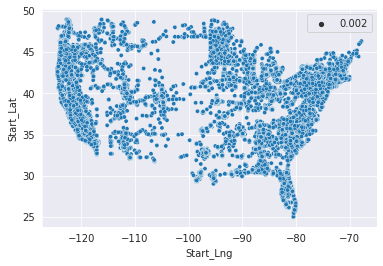

In [22]:
sns.scatterplot(x = location_df.Start_Lng, y = location_df.Start_Lat, size = 0.002)

In [23]:
latitude_longitude_pairs = list(zip(list(location_df.Start_Lat), list(location_df.Start_Lng)))

In [ ]:
map = folium.Map()
HeatMap(latitude_longitude_pairs, radius=20).add_to(map)
map

Let's get a more granular look into each of the states.

In [88]:
col_list = []
col_list.append(weather_df.groupby(by='State')['ID'].count())
for col in ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Distance(mi)']:
  avg_df = pd.DataFrame({f'avg_{col}': weather_df.groupby(by='State')[f'{col}'].mean()})
  median_df = pd.DataFrame({f'median_{col}': weather_df.groupby(by='State')[f'{col}'].median()})
  col_list.append(avg_df)
  col_list.append(median_df)
per_state = pd.concat(col_list, axis=1).rename(columns={'ID':'num_accidents'}).sort_values(by='num_accidents', ascending=False)

In [146]:
per_state

,num_accidents,avg_Temperature(F),median_Temperature(F),avg_Wind_Chill(F),median_Wind_Chill(F),avg_Humidity(%),median_Humidity(%),avg_Visibility(mi),median_Visibility(mi),avg_Wind_Speed(mph),median_Wind_Speed(mph),avg_Precipitation(in),median_Precipitation(in),avg_Distance(mi),median_Distance(mi)
State,,,,,,,,,,,,,,,
CA,175919,51.329514,53.0,50.809705,53.0,71.713033,76.0,8.499376,10.0,4.341192,3.0,0.006979,0.0,0.233695,0.0000
OR,47389,44.763164,45.0,42.400745,42.5,78.475406,83.0,8.405169,10.0,6.672044,6.0,0.008257,0.0,0.728888,0.0730
MN,45901,27.467450,28.0,19.800619,21.0,76.643428,79.0,7.799774,10.0,9.345382,8.0,0.002562,0.0,0.572693,0.0050
NY,43219,41.371556,42.0,36.904244,37.7,72.063907,76.0,8.141543,10.0,9.391883,8.1,0.018399,0.0,0.590826,0.0100
PA,33345,41.945446,43.0,38.672689,39.0,73.398111,76.0,8.186396,10.0,7.041658,6.0,0.006806,0.0,0.895427,0.0920
TX,26937,48.364617,49.0,46.173089,47.0,72.238928,76.0,8.791128,10.0,7.916156,7.0,0.007083,0.0,0.296502,0.0130
VA,26821,45.676832,47.0,43.745871,44.0,74.561016,80.0,8.847909,10.0,5.999579,6.0,0.006628,0.0,0.824292,0.1940
SC,26153,47.214201,48.0,45.845253,46.0,74.809391,81.0,8.842672,10.0,4.843704,5.0,0.006004,0.0,0.194951,0.0000
NC,26010,46.961915,48.0,45.396959,46.0,74.733948,80.0,8.465482,10.0,5.427551,5.0,0.009046,0.0,0.317745,0.0000


Let's also look at the most popular times of the day when accidents happen in each state and for how long an accident typically lasted. 

In [145]:
time_df = pd.DataFrame(
    {   'ID': weather_df.ID,
        'start_hour': weather_df.Start_Time.astype(str).str[11:13],
        'end_hour': weather_df.End_Time.astype(str).str[11:13],
        'duration': weather_df.End_Time.astype(str).str[11:13].astype(float) - weather_df.Start_Time.astype(str).str[11:13].astype(float)
     })
time_df['duration'] = time_df['duration'].mask(time_df['duration'] < 0, 24 + time_df['duration'])

In [135]:
time_df

,ID,start_hour,end_hour,duration
2,A-3,21,22,1.0
6,A-7,09,10,1.0
7,A-8,23,00,1.0
9,A-10,08,09,1.0
10,A-11,08,10,2.0
...,...,...,...,...
2906576,A-2906577,22,23,1.0
2906579,A-2906580,22,00,2.0
2906591,A-2906592,08,11,3.0
2906602,A-2906603,03,05,2.0


In [140]:
time_df['duration'].mode()

0    1.0
dtype: float64

In [141]:
time_df['duration'].mean()

1.9969613476689636

In [139]:
time_df['start_hour'].mode()

0    07
dtype: object

In [138]:
time_df['end_hour'].mode()

0    08
dtype: object

We can see now that majority of accidents last for one hour. The most frequest time an accident occurs is at 7AM, and the most frequest time it ends is at 8AM.

Let's now break those values up per state.

- [ ] initial analysis 
  - [x] how many accidents per state
  - when do the most accidents happen? (around holidays? in summer/winter? day/night?)
  - [x] average distance of accident
- more in depth 
  - [ ] select a subset of columns to look at 
  - [ ] make question list of what going to be answering and specifically looking at in the notebook

# Questions to consider
- Does weather condition make an impact in the severity of the accident? 
  - i.e if there was rain/hail/snow is the accident more severe? 
  - What type of weather correlates to the most severity? (does driving in snow/hail/rain have a greater effect on severity)

- Digging deeper into weather:
    - what about weather at night vs in the day? 
       - does raining during the night make it worse to drive in, causing more accidents than raining during the day? 
    - Does faster rain/snow/rain relate to more accidents? 

- Connection between severity and weather condition? 
  - include wind speed as well 
  - increased wind speed could lead to decreased visibility when paired with precipitation

#References

*   Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

* Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

*   https://www.ibm.com/cloud/learn/exploratory-data-analysis 
*   https://www.stat.cmu.edu/~hseltman/309/Book/chapter4.pdf 
* https://pandas.pydata.org/pandas-docs/stable/reference/general_functions.html
* https://www.timeanddate.com/astronomy/different-types-twilight.html 
* https://www.washingtonpost.com/weather/2020/08/16/death-valley-heat-record/
* https://www.mountwashington.org/about-us/history/world-record-wind.aspx#:~:text=For%20nearly%20sixty%2Dtwo%20years,by%20Mount%20Washington%20Observatory%20staff. 